# AI 201 Programming Assignment 2
## Naive Bayes Spam Filter

Submitted by: 
Jan Lendl R. Uy, 2019-00312

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import re
import random
import numpy as np

In [2]:
# File constants
DATASET_PATH_STRING = "trec06p-ai201/data"
FOLDER_COUNT = 127
FILE_COUNT = 300

## Classifier Construction and Evaluation

### Parse the documents from the dataset

Reads the contents of the TREC06 Dataset

In [3]:
# Extract the features from TREC06 Dataset
documents = []

for i in range(FOLDER_COUNT):
    folder_count = str(i)
    # Convert folder digit directory to a 3-character string
    if len(folder_count) < 3:
        folder_count = "0" * (3-len(folder_count)) + folder_count
    for j in range(FILE_COUNT):
        file_count = str(j)
        # Convert digit filename to a 3-character string
        if len(file_count) < 3:
            file_count = "0" * (3-len(file_count)) + file_count
        directory_path = f"{DATASET_PATH_STRING}/{folder_count}/{file_count}"
        try:
            with open(file=directory_path, 
                    mode="r", 
                    encoding="utf-8", 
                    errors="replace") as file:
                content = file.read().replace("�", "")
                documents.append(content)
        except:
            print(f"No more files left to read!")
            break
        # print(f"{directory_path}")

No more files left to read!


In [4]:
# Extract the labels from TREC06 Dataset
labels = []

df_labels = pd.read_csv("trec06p-ai201/labels", header=None)
labels_in_list = df_labels.values.tolist()

for label in labels_in_list:
    label_in_str = str(label).rsplit(" ")
    labels.append(label_in_str[0][2:])

### Disjoint training and test sets containing ham and spam 

Split is as follows: 70\% training and 30\% test

In [5]:
def custom_train_test_split(X, Y, test_size=0.3, random_state=None):    
    # Pair each document with its label
    paired = list(zip(X, Y))
    
    # Shuffle the paired documents and labels
    if random_state is not None:
        # Set the randomization seed if provided
        # To allow reproducibility of the randomization
        rng = random.Random(random_state)
        rng.shuffle(paired)
    else:
        random.shuffle(paired)
    
    # Calculate the number of samples in the test set
    if isinstance(test_size, float):
        test_size = int(test_size * len(X))
    
    # Split the paired list into training and testing sets
    train_pairs = paired[:-test_size]
    test_pairs = paired[-test_size:]
    
    # Unzip the pairs back into separate lists
    train_docs, train_labels = zip(*train_pairs)
    test_docs, test_labels = zip(*test_pairs)
    
    return list(train_docs), list(test_docs), list(train_labels), list(test_labels)

In [6]:
X_train, X_test, Y_train, Y_test = custom_train_test_split(documents, labels, 0.3, random_state=62)

In [7]:
class Vocabulary:
    
    def __init__(self, documents, labels):
        # Assuming 'documents' is a list of strings (each string is a document),
        # and 'labels' is a list of labels ('spam' or 'ham') corresponding to each document.
        
        self.contents = set()
        
        self.word_counts = {"spam": {}, "ham": {}}
        self.spam_count = 0
        self.ham_count = 0

        # Preprocess documents and build vocabulary
        for document, label in zip(documents, labels):
            # Tokenize the document
            words = re.findall("[a-zA-Z]+", document)
            # Convert all words to lowercase to avoid classifying
            # same words but different cases as different
            # lowercase_words = [word.lower() for word in words]
            unique_words = set(words)
            
            # Update vocabulary
            self.contents.update(unique_words)
            
            # Count word statistics
            for word in unique_words:
                if word not in self.word_counts[label]:
                    self.word_counts[label][word] = 0
                self.word_counts[label][word] += 1
            
            # Count documents in each class
            if label == "spam":
                self.spam_count += 1
            else:
                self.ham_count += 1

        # Calculate prior probabilities
        total_documents = self.spam_count + self.ham_count
        self.prior_spam = self.spam_count / total_documents
        self.prior_ham = self.ham_count / total_documents
        
        self.size = len(self.contents)
                
        # Initialize log likelihoods
        self.log_likelihoods = {
            "spam": {word: 0 for word in self.contents},
            "ham": {word: 0 for word in self.contents},
        }
        
    def show_vocabulary_statistics(self):
        
        print(f"Vocabulary size: {self.size}")
        print(f"Prior probability of spam: {self.prior_spam}")
        print(f"Prior probability of ham: {self.prior_ham}")
    
    def get_prior_probabilities(self):
        
        return np.log(self.prior_spam), np.log(self.prior_ham)
    
    def calculate_word_probabilities(self):
        # Calculate P(word) and P(word|class)
        self.word_probabilities = {}  # P(word)
        self.conditional_probabilities = {"spam": {}, "ham": {}}  # P(word|class)

        total_spam_words = sum(self.word_counts['spam'].values())
        total_ham_words = sum(self.word_counts['ham'].values())
        total_words = total_spam_words + total_ham_words

        for word in self.contents:
            spam_word_count = self.word_counts['spam'].get(word, 0)
            ham_word_count = self.word_counts['ham'].get(word, 0)
            
            # P(word)
            self.word_probabilities[word] = (spam_word_count + ham_word_count) / total_words
            
            # P(word|spam) and P(word|ham)
            self.conditional_probabilities['spam'][word] = spam_word_count / self.spam_count if self.spam_count else 0
            self.conditional_probabilities['ham'][word] = ham_word_count / self.ham_count if self.ham_count else 0

    def calculate_mutual_information(self):
        self.mi_scores = {}
        for word in self.contents:
            mi_score = 0
            for label in ['spam', 'ham']:
                for word_presence in [True, False]:
                    if word_presence:
                        p_w_c = self.conditional_probabilities[label].get(word, 0)
                        p_w = self.word_probabilities.get(word, 0)
                    else:
                        p_w_c = 1 - self.conditional_probabilities[label].get(word, 0)
                        p_w = 1 - self.word_probabilities.get(word, 0)
                    
                    p_c = self.prior_spam if label == 'spam' else self.prior_ham
                    p_w_and_c = p_w_c * p_c
                    
                    if p_w_and_c > 0 and p_w > 0 and p_c > 0:
                        mi_score += p_w_and_c * np.log(p_w_and_c / (p_w * p_c))
            
            self.mi_scores[word] = mi_score
            
    def rebuild_vocabulary_with_top_words(self, top_words):
        # Filter the contents to include only the top words
        self.contents = set(top_words)
        
        # Filter the word counts for both 'spam' and 'ham' to include only the top words
        for label in ['spam', 'ham']:
            self.word_counts[label] = {word: count for word, count in self.word_counts[label].items() if word in top_words}
        
        # Since the vocabulary has changed, you might need to update any other computed statistics
        # For example, you may choose to recalculate the prior probabilities, log likelihoods, etc.
        # depending on whether those calculations are dependent on the full vocabulary or not.
        self.size = len(self.contents)  # Update the size of the vocabulary
        
        # Optionally recalculate probabilities if your implementation requires it
        # This might be necessary if your class methods depend on the updated vocabulary
        self.calculate_word_probabilities()
        self.calculate_mutual_information()


In [8]:
vocabulary = Vocabulary(X_train, Y_train)
vocabulary.show_vocabulary_statistics()

Vocabulary size: 2181436
Prior probability of spam: 0.6562924913128871
Prior probability of ham: 0.34370750868711286


### Construct and train a Naive Bayesian Classifier from the count statistics

The Naive Bayes Classifier is implemented as a class with two methods, `train()` and `predict()`. `train()` is reminiscent of the `fit()` method in sklearn which trains the model for a given training set. On the other hand, `predict()` is similar to that of sklearn `predict()` which returns the inferences of the model for a given test set.

In [9]:
class NaiveBayesClassifier:
    
    def __init__(self, lambda_value=0):
        # Laplace smoothing factor
        # By default, there is no Laplace smoothing
        self.lambda_value = lambda_value
    
    def train(self, vocabulary):        
        # Calculate log likelihoods for each word
        spam_count = vocabulary.spam_count
        ham_count = vocabulary.ham_count
        vocabulary_size = vocabulary.size
        word_counts = vocabulary.word_counts
        
        for word in vocabulary.contents:
            # Calculate the likelihood of word given spam
            spam_word_count = word_counts["spam"].get(word, 0)
            spam_likelihood = (spam_word_count + self.lambda_value) / (spam_count + self.lambda_value * vocabulary_size)
            vocabulary.log_likelihoods["spam"][word] = np.log(spam_likelihood)
            
            # Calculate the likelihood of word given ham
            ham_word_count = word_counts["ham"].get(word, 0)
            ham_likelihood = (ham_word_count + self.lambda_value) / (ham_count + self.lambda_value * vocabulary_size)
            vocabulary.log_likelihoods["ham"][word] = np.log(ham_likelihood)

    def predict(self, vocabulary, X_test):        
        predictions = []
        
        for document in X_test:
            words = re.findall("[a-zA-Z]+", document)
            # Convert all words to lowercase to avoid classifying
            # same words but different cases as different
            # lowercase_words = [word.lower() for word in words]
            spam_score, ham_score = vocabulary.get_prior_probabilities()
            for word in words:
                if word in vocabulary.log_likelihoods["spam"]:
                    spam_score += vocabulary.log_likelihoods["spam"][word]
                if word in vocabulary.log_likelihoods["ham"]:
                    ham_score += vocabulary.log_likelihoods["ham"][word]
        
            predictions.append("spam" if spam_score > ham_score else "ham")
            
        return predictions


In [10]:
classifier = NaiveBayesClassifier(lambda_value=0)
classifier.train(vocabulary)

/var/folders/cq/5p30h6x5741g3nvfdq8t32g40000gn/T/ipykernel_1421/4269419531.py:19: RuntimeWarning: divide by zero encountered in log
  vocabulary.log_likelihoods["spam"][word] = np.log(spam_likelihood)
/var/folders/cq/5p30h6x5741g3nvfdq8t32g40000gn/T/ipykernel_1421/4269419531.py:24: RuntimeWarning: divide by zero encountered in log
  vocabulary.log_likelihoods["ham"][word] = np.log(ham_likelihood)


### Compute the precision and recall of the initial model

In [11]:
def get_precision(predicted_labels, actual_labels):
    true_positive = sum(1 for predicted, actual in zip(predicted_labels, actual_labels) if predicted == actual and actual == "spam")
    false_positive = sum(1 for predicted, actual in zip(predicted_labels, actual_labels) if predicted == "spam" and actual == "ham")
    
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
        
    return precision

def get_recall(predicted_labels, actual_labels):
    true_positive = sum(1 for predicted, actual in zip(predicted_labels, actual_labels) if predicted == actual and actual == "spam")
    false_negative = sum(1 for predicted, actual in zip(predicted_labels, actual_labels) if predicted == "ham" and actual == "spam")
        
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    
    return recall

In [12]:
Y_pred = classifier.predict(vocabulary, X_test)
print(f"Precision of the Initial Naive Bayes Classifier: {get_precision(Y_pred, Y_test)}")
print(f"Recall of the Initial Naive Bayes Classifier: {get_recall(Y_pred, Y_test)}")

Precision of the Initial Naive Bayes Classifier: 0.9992487980769231
Recall of the Initial Naive Bayes Classifier: 0.8825636942675159


## Lambda Smoothing

Uses λ smoothing for 5 different values of λ. Resulting precision and recall are displayed for these lambda values.

Precision of the Naive Bayes Classifier for (λ = 0.005): 0.9916456703354992
Recall of the Naive Bayes Classifier for (λ = 0.005): 0.9923036093418259

Precision of the Naive Bayes Classifier for (λ = 0.1): 0.9675967596759676
Recall of the Naive Bayes Classifier for (λ = 0.1): 0.9985403397027601

Precision of the Naive Bayes Classifier for (λ = 0.5): 0.953170484748766
Recall of the Naive Bayes Classifier for (λ = 0.5): 0.9993365180467091

Precision of the Naive Bayes Classifier for (λ = 1): 0.9423245339672213
Recall of the Naive Bayes Classifier for (λ = 1): 0.9994692144373672

Precision of the Naive Bayes Classifier for (λ = 2): 0.9302296863423067
Recall of the Naive Bayes Classifier for (λ = 2): 0.9996019108280255



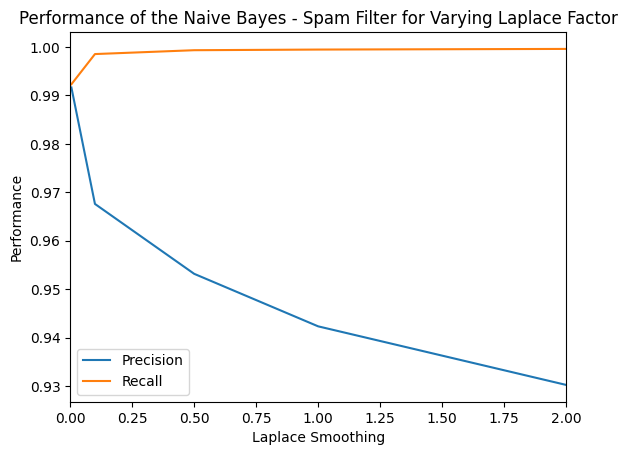

In [13]:
lambda_values = [0.005, 0.1, 0.5, 1, 2]
precision_values = []
recall_values = []

for lambda_value in lambda_values:
    # Initialize and train the classifier
    classifier = NaiveBayesClassifier(lambda_value=lambda_value)
    classifier.train(vocabulary)
    # Evaluate the resulting performance as a result of tuning lambda
    Y_pred = classifier.predict(vocabulary, X_test)
    precision = get_precision(Y_pred, Y_test)
    recall = get_recall(Y_pred, Y_test)
    precision_values.append(precision)
    recall_values.append(recall)
    print(f"Precision of the Naive Bayes Classifier for (λ = {lambda_value}): {precision}")
    print(f"Recall of the Naive Bayes Classifier for (λ = {lambda_value}): {recall}\n")
    
plt.plot(lambda_values, precision_values, label="Precision")
plt.plot(lambda_values, recall_values, label="Recall")
plt.title("Performance of the Naive Bayes - Spam Filter for Varying Laplace Factor")
plt.xlabel("Laplace Smoothing")
plt.ylabel("Performance")
plt.xlim((0, 2))
plt.legend()
plt.show()

**Answer**: Based on the plot above, a Laplace factor of 0.005 achieves the best balance between a high precision and a high recall. Since the precision trends exponentially downward at a faster rate than than the rate of increase in recall, the Laplace factor is ideally set as low as possible but not equal to zero as this tends to result in zero division, causing instability to the model. For the lambda values tested, 0.005 is the best smoothing factor that maximizes both the precision and recall of the Naive Bayes spam classifier.

## Improving the Classifier

In [14]:
# Obtain the top 200 most informative words based on the mutual information of each word
# in relation to its label
vocabulary.calculate_word_probabilities()
vocabulary.calculate_mutual_information()

# Sort words by their MI score and select the top 200
vocabulary_top_200 = sorted(vocabulary.mi_scores, key=vocabulary.mi_scores.get, reverse=True)[:200]
print(vocabulary_top_200)

['by', 'Received', 'from', 'with', 'id', 'From', 'To', 'Subject', 'for', 'edu', 'Date', 'Content', 'Type', 'Version', 'Message', 'text', 'a', 'ESMTP', 'charset', 'X', 'plain', 'com', 'Encoding', 'Transfer', 'to', 'MIME', 'http', 'in', 'is', 'the', 'and', 'of', 'ID', 'bit', 'Mailer', 'c', 's', 'A', 'I', 'us', 'b', 'C', 'html', 'Reply', 'you', 'B', 'This', 'mit', 'net', 'SMTP', 'it', 'media', 'aleve', 'on', 'this', 'Id', 'that', 'D', 't', 'handyboard', 'be', 'd', 'format', 'message', 'boundary', 'multipart', 'have', 'at', 'f', 'alternative', 'Mime', 'E', 'href', 'i', 'your', 'The', 'unknown', 'e', 'F', 'p', 'or', 'V', 'are', 'content', 'part', 'Microsoft', 'not', 'www', 'ascii', 'equiv', 'Priority', 'EDT', 'size', 'EST', 'multi', 'By', 'ALEVE', 'can', 'br', 'v', 'u', 'out', 'as', 'localhost', 'mail', 'will', 'our', 'Normal', 'all', 'k', 'm', 'M', 'Re', 'W', 'color', 'border', 'but', 'font', 'body', 'Sender', 'j', 'n', 'P', 'Outlook', 'width', 'S', 'an', 'G', 'L', 'align', 'has', 'center'

In [19]:
labels = []
for word in vocabulary_top_200:
    if word in vocabulary.log_likelihoods["spam"]:
        labels.append("spam")
    else:
        labels.append("ham")
print(labels)

['spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam',

In [20]:
# Rebuild the vocabulary with the top 200 most informative words
vocabulary_reduced = Vocabulary(vocabulary_top_200, labels)

# Initialize and train the classifier
best_lambda = 0.005
classifier = NaiveBayesClassifier(lambda_value=best_lambda)
classifier.train(vocabulary_reduced)

# Evaluate the resulting performance of classifier with the reduced vocabulary
Y_pred = classifier.predict(vocabulary_reduced, X_test)
precision = get_precision(Y_pred, Y_test)
recall = get_recall(Y_pred, Y_test)
print(f"Precision of the Naive Bayes Classifier with Top 200 Vocabulary for (λ = {best_lambda}): {precision}")
print(f"Recall of the Naive Bayes Classifier with Top 200 Vocabulary for (λ = {best_lambda}): {recall}\n")

/var/folders/cq/5p30h6x5741g3nvfdq8t32g40000gn/T/ipykernel_1421/2310973827.py:58: RuntimeWarning: divide by zero encountered in log
  return np.log(self.prior_spam), np.log(self.prior_ham)


Precision of the Naive Bayes Classifier with Top 200 Vocabulary for (λ = 2): 0.6641988365943945
Recall of the Naive Bayes Classifier with Top 200 Vocabulary for (λ = 2): 1.0

